In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm

import ROOT
from array import array

Welcome to JupyROOT 6.26/04


In [2]:
run = [627,632]
pad_name = [37,38,27,28]

In [3]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]


In [4]:
cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/cable_delay.txt')
#cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/cable_delay.txt')
pad_slew = []

for index in range(4):
    pad = index+1
    pad_slew.append(np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/slew_pad{pad}.txt',
                        comments="#", delimiter=" ", unpack=False))
    
    print(pad_slew[index].shape)


(45, 7)
(45, 7)
(45, 7)
(45, 7)


In [5]:
p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))

for index in range(4):
    pad_slew[index][:,3] =  pad_slew[index][:,3] - cable_delay[index]+10 # correctfor cables time delay+10 ps
    pad_slew[index][:,0] =  p2[index]*pad_slew[index][:,0]+p3[index]# scale charge of pads
    print(p2[index], p3[index])

1.0 0.0
0.9198626164261511 -0.06428747078179269
0.948264591418022 -0.03160710777975936
0.9192696415398678 -0.1714705509772368


In [6]:
#pad_slew[0][:,0] =  pad_slew[0][:,0]-0.12# open in sharing runs
#pad_slew[0][:,0] =  0.98*pad_slew[0][:,0]-0.12# open in resolution for scanning runs
#pad_slew[2][:,0] =  0.98*pad_slew[2][:,0]-0.12

#pad_slew[0][:,0] =  1.075*pad_slew[0][:,0]

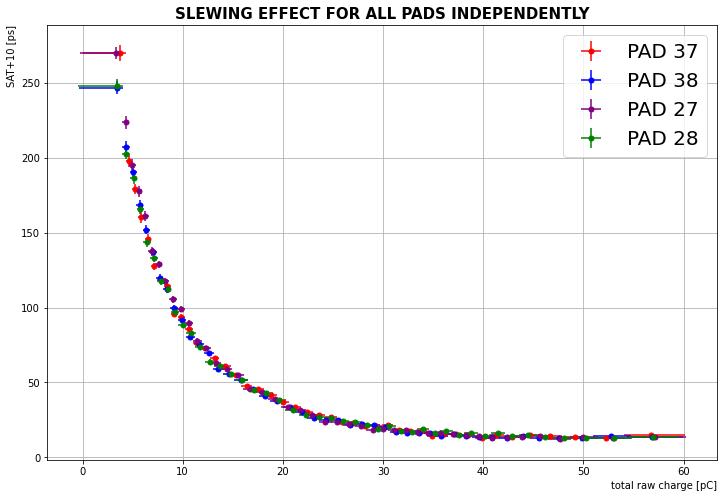

In [7]:
#create combined graph
#"mean_q" "error_low_q" "error_high_q" 
#"SAT"  "SAT_error" "resolution (not corrected)" "resolution_error (not corrected)"
fig, ax = plt.subplots(figsize=(12,8))
color = np.array(['red','blue','purple','green'])

for index in [0,1,2,3]:
    pad = index+1

    q = pad_slew[index][:-1,0]
    q_error=[pad_slew[index][:-1,1],pad_slew[index][:-1,2]]
    sat =  pad_slew[index][:-1,3] 
    sat_error = pad_slew[index][:-1,4]
    plt.errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',
             label =f'PAD {pad_name[index]}',color = color[index], markersize=5. )


ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('SAT+10 [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 20})
#ax.set_yscale('log')
ax.set_title('SLEWING EFFECT FOR ALL PADS INDEPENDENTLY', fontsize=15, fontweight='bold')

plt.show()

In [8]:
all_pads_slew = np.concatenate([pad_slew[index][:-1,:] for index in range(4)])

all_pads_slew.shape

(176, 7)

In [9]:
q_all = all_pads_slew[:,0]
q_all_error = [all_pads_slew[:,1], all_pads_slew[:,2]]
sat_all = all_pads_slew[:,3]
sat_all_error = all_pads_slew[:,4]

In [10]:
par = np.array([-0.5,5.,-0.5,5.,10])

popt, pcov = curve_fit(double_expo, q_all, sat_all,sigma=sat_all_error, p0= par, absolute_sigma=True)
par = popt
par_errors = np.sqrt(np.diag(pcov))
print(par)
print(par_errors)

[-0.11990218  5.5298188  -0.47333415  5.99750354 12.49458982]
[0.00163381 0.02738138 0.03072179 0.08567188 0.12021821]


/tmp/ipykernel_50545/1126551636.py:13: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]


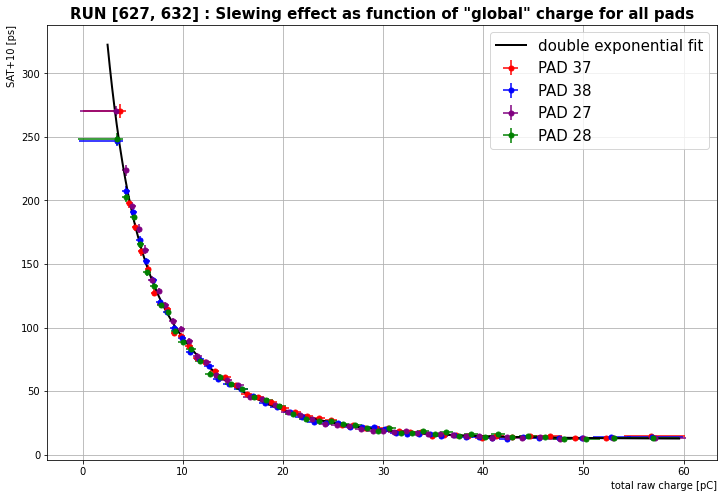

In [11]:
x = np.linspace(2.5,q[-1]+q_error[1][-1],1000)
y = double_expo(x,*par)

fig, ax = plt.subplots(figsize=(12,8))

for index in range(4):
    pad = index+1

    q = pad_slew[index][:-1,0]
    q_error=[pad_slew[index][:-1,1],pad_slew[index][:-1,2]]
    sat =  pad_slew[index][:-1,3] 
    sat_error = pad_slew[index][:-1,4]
    plt.errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',
             label =f'PAD {pad_name[index]}',color = color[index], markersize=5. )

fit_lab = 'double exp fit \n p0 = {:.3f}\n p1 = {:.3f}\n p2 = {:.3f}\n p3 = {:.3f}\n p4 = {:.3f}\n '.format(par[0],
                                                                                          par[1],
                                                                                          par[2],
                                                                                          par[3],
                                                                                          par[4])             
ax.plot(x,y,color='black',linewidth='2',label='double exponential fit')

ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('SAT+10 [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 15})
#ax.set_yscale('log')
ax.set_title(f'RUN {run} : Slewing effect as function of "global" charge for all pads',
             fontsize=15, fontweight='bold')

plt.show()

with open(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/slew_fit.txt', 'w') as f:
    np.savetxt(f,par)
    

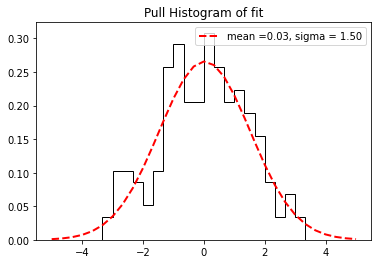

In [12]:
pull_values = (sat_all - double_expo(q_all,*par))/sat_all_error
n, bins, patches = plt.hist(pull_values,bins =30, range=[-5,5],
                            histtype='step',density=True,color='black')

#gaus fit
(mu, sigma) = norm.fit(pull_values)

prob = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, prob, 'r--', linewidth=2,label = f'mean ={mu:.2f}, sigma = {sigma:.2f}')

plt.title('Pull Histogram of fit')
plt.legend()
plt.show()

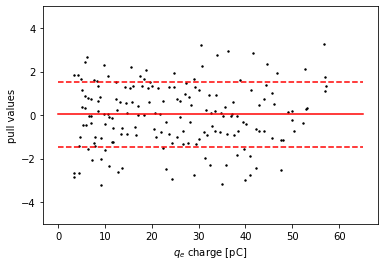

In [13]:
plt.scatter(q_all, (pull_values),color = 'black', s=2.)
plt.plot(np.linspace(0,65,100),np.ones(100)*mu,color='r')
plt.plot(np.linspace(0,65,100),np.ones(100)*(mu+sigma),'r--')
plt.plot(np.linspace(0,65,100),np.ones(100)*(mu-sigma),'r--')

plt.ylim(-5,5)
plt.xlabel(r'$q_e$ charge [pC]')
plt.ylabel('pull values')

plt.show()

In [14]:
par_up = par+np.array([0,0,0,0,sigma*sat_all_error.mean()])
par_down = par-np.array([0,0,0,0,sigma*sat_all_error.mean()])

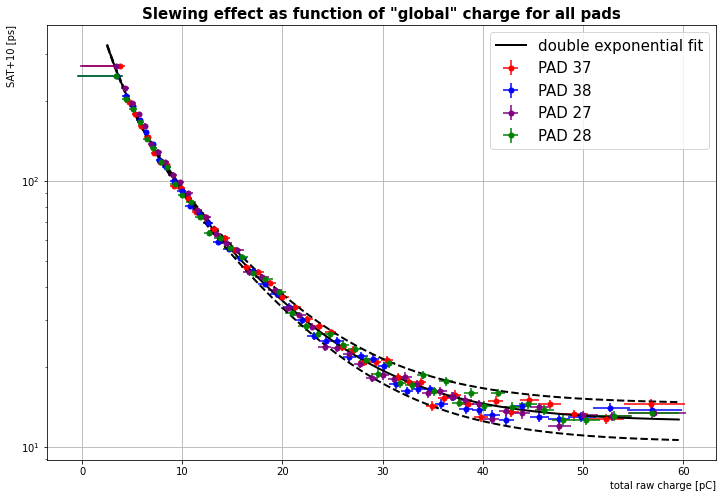

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

for index in range(4):
    pad = index+1

    q = pad_slew[index][:-1,0]
    q_error=[pad_slew[index][:-1,1],pad_slew[index][:-1,2]]
    sat =  pad_slew[index][:-1,3] 
    sat_error = pad_slew[index][:-1,4]
    plt.errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',
             label =f'PAD {pad_name[index]}',color = color[index], markersize=5. )


ax.plot(x,y,color='black',linewidth='2',label='double exponential fit')
ax.plot(x,double_expo(x,*par_up),'--',color='black',linewidth='2')
ax.plot(x,double_expo(x,*par_down),'--',color='black',linewidth='2')

ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('SAT+10 [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 15})
ax.set_yscale('log')
ax.set_title('Slewing effect as function of "global" charge for all pads', fontsize=15, fontweight='bold')

plt.show()

In [16]:
res_par = np.array([-0.5,5.,-0.5,5.,15])

popt, pcov = curve_fit(double_expo, q_all, all_pads_slew[:,5],sigma=all_pads_slew[:,6], p0= res_par, 
                       absolute_sigma=True)
res_par = popt
res_par_errors = np.sqrt(np.diag(pcov))
print(res_par)
print(res_par_errors)

[-0.32849046  5.07849407 -0.08403142  4.27988861 14.19658886]
[0.02408139 0.06213113 0.00332721 0.06510915 0.18175561]


/tmp/ipykernel_50545/1126551636.py:13: RuntimeWarning: overflow encountered in exp
  return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]


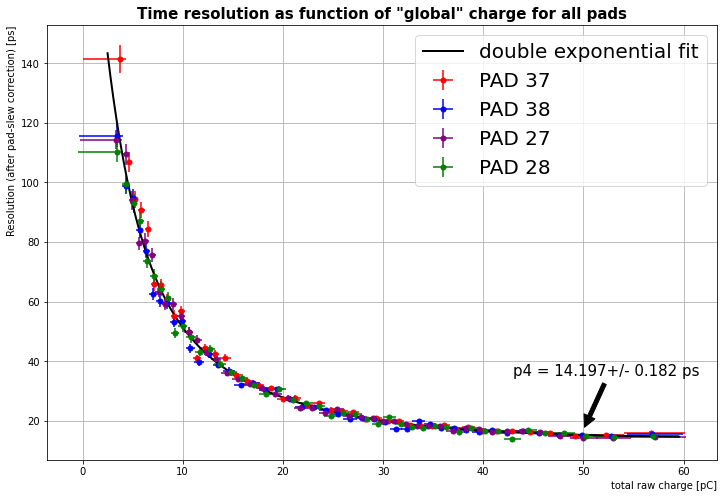

In [17]:
fig, ax = plt.subplots(figsize=(12,8))

for index in range(4):
    pad = index+1

    q = pad_slew[index][:-1,0]
    q_error=[pad_slew[index][:-1,1],pad_slew[index][:-1,2]]
    res =  pad_slew[index][:-1,5] 
    res_error = pad_slew[index][:-1,6]
    plt.errorbar(q,res, yerr =res_error ,xerr=q_error,fmt='o',
             label =f'PAD {pad_name[index]}',color = color[index], markersize=5. )


x = np.linspace(2.5,q[-1]+q_error[1][-1],1000)
y = double_expo(x,*res_par)
ax.plot(x,y,color='black',linewidth='2',label='double exponential fit')
ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('Resolution (after pad-slew correction) [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 20})
#ax.set_yscale('log')
ax.set_title('Time resolution as function of "global" charge for all pads', fontsize=15, fontweight='bold')

ax.annotate(f'p4 = {res_par[4]:.3f}+/- {res_par_errors[4]:.3f} ps', xy=(50, 17), xytext=(43, 35),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)

plt.show()

In [18]:
combined_pads = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/slew_all_pads.txt',
                        comments="#", delimiter=" ", unpack=False)
len(combined_pads)

65

[-0.12444769  5.65353771 -0.80580384  8.39258201 13.09118277]
[0.00119331 0.01729954 0.040359   0.19329236 0.10561416]


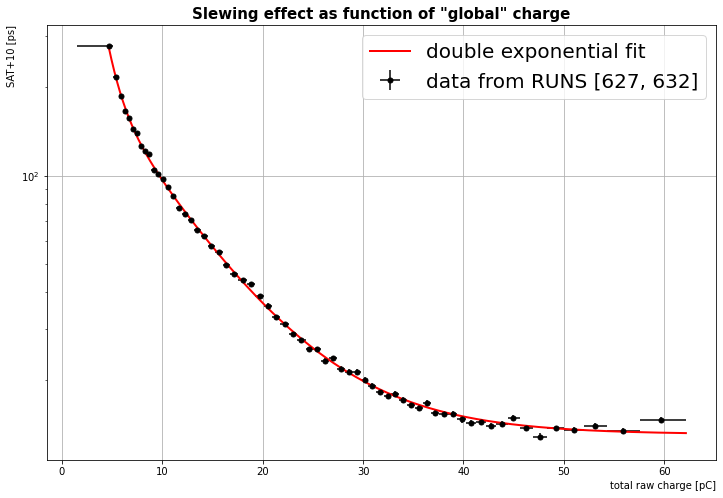

In [19]:
fig, ax = plt.subplots(figsize=(12,8))

q = combined_pads[:-1,0]
q_error=[combined_pads[:-1,1],combined_pads[:-1,2]]
sat =  combined_pads[:-1,3] 
sat_error = combined_pads[:-1,4]

combined_par = par
popt, pcov = curve_fit(double_expo, q, sat,sigma=sat_error, p0= combined_par, absolute_sigma=True)
combined_par = popt
combined_par_errors = np.sqrt(np.diag(pcov))
with open(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/global_slew_fit.txt', 'w') as f:
    np.savetxt(f,combined_par)

print(combined_par)
print(combined_par_errors)

plt.errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',label = f'data from RUNS {run}',
             color = 'black', markersize=5. )

x = np.linspace(q[0],q[-1]+q_error[1][-1],1000)
y = double_expo(x,*combined_par)
ax.plot(x,y,color='red',linewidth='2',label='double exponential fit')

ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('SAT+10 [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 20})
ax.set_yscale('log')
ax.set_title('Slewing effect as function of "global" charge', fontsize=15, fontweight='bold')

plt.show()

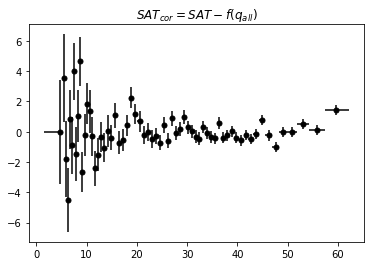

In [20]:
dy = (sat - double_expo(q,*combined_par))
plt.errorbar(q,dy, yerr =sat_error ,xerr=q_error,fmt='o',color = 'black', markersize=5. )
plt.title(r'$SAT_{cor} = SAT - f(q_{all})$')

plt.show()

In [21]:
pull_values = (sat - double_expo(q,*combined_par))/sat_error    
combined_sigma  = pull_values.std()

com_par_up = combined_par+np.array([0,0,0,0,combined_sigma*sat_error.mean()])
com_par_down = combined_par-np.array([0,0,0,0,combined_sigma*sat_error.mean()])

par_up = par+np.array([0,0,0,0,sigma.mean()*sat_all_error.mean()])
par_down = par-np.array([0,0,0,0,sigma.mean()*sat_all_error.mean()])

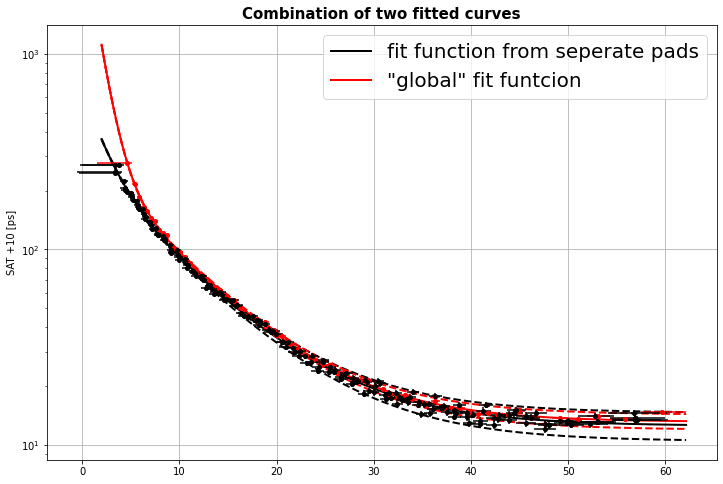

In [22]:
fig=plt.figure(figsize=(12,8))
x = np.linspace(2.,q[-1]+q_error[1][-1],1000)

plt.plot(x,double_expo(x,*par),color='black',linewidth='2',label='fit function from seperate pads')
plt.plot(x,double_expo(x,*par_up),'--',color='black',linewidth='2')
plt.plot(x,double_expo(x,*par_down),'--',color='black',linewidth='2')
plt.plot(x,double_expo(x,*combined_par),color='red',linewidth='2',label='"global" fit funtcion')
plt.plot(x,double_expo(x,*com_par_up),'r--',linewidth='2')
plt.plot(x,double_expo(x,*com_par_down),'r--',linewidth='2')

plt.errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',
             color = 'r', markersize=4. )
plt.errorbar(q_all,sat_all, yerr =sat_all_error ,xerr=q_all_error,fmt='o',
             color = 'black', markersize=4. )

plt.yscale('log')
plt.title('Combination of two fitted curves',fontsize=15, fontweight='bold')
plt.ylabel('SAT +10 [ps]')
plt.legend(prop={'size': 20})
plt.grid()

#plt.ylim(70,150)
#plt.xlim(0,5)
plt.show()

[-0.5133157   6.23749482 -0.09119926  4.48786529 14.68728293]
[0.03924548 0.1914957  0.0020871  0.03567212 0.12919321]


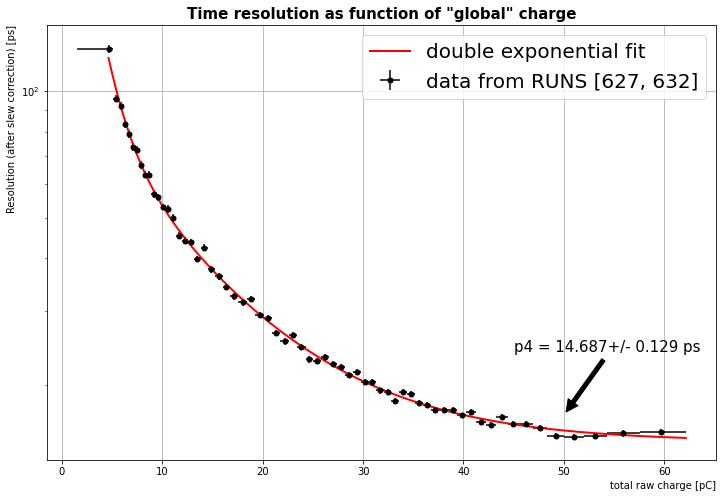

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
res =  combined_pads[:-1,5] 
res_error = combined_pads[:-1,6]
plt.errorbar(q,res, yerr =res_error ,xerr=q_error,fmt='o',
             label =f'data from RUNS {run}',color = 'black', markersize=5. )

combined_res = res_par
popt, pcov = curve_fit(double_expo, q, res,sigma=res_error, p0= combined_res, absolute_sigma=True)
combined_res = popt
combined_res_errors = np.sqrt(np.diag(pcov))
print(combined_res)
print(combined_res_errors)

x = np.linspace(q[0],q[-1]+q_error[1][-1],1000)
y = double_expo(x,*combined_res)
ax.plot(x,y,color='red',linewidth='2',label='double exponential fit')

ax.set_xlabel('total raw charge [pC]',loc='right')
ax.set_ylabel('Resolution (after slew correction) [ps]',loc='top')
ax.grid()
ax.legend(prop={'size': 20})
ax.set_yscale('log')
ax.set_title('Time resolution as function of "global" charge', fontsize=15, fontweight='bold')

ax.annotate(f'p4 = {combined_res[4]:.3f}+/- {combined_res_errors[4]:.3f} ps', xy=(50, 17), xytext=(45, 24),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)

plt.show()

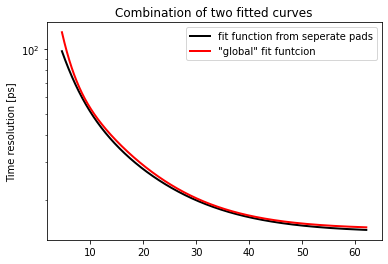

In [24]:
plt.plot(x,double_expo(x,*res_par),color='black',linewidth='2',label='fit function from seperate pads')
plt.plot(x,double_expo(x,*combined_res),color='red',linewidth='2',label='"global" fit funtcion')
plt.yscale('log')
plt.title('Combination of two fitted curves')
plt.ylabel('Time resolution [ps]')
plt.legend()
plt.show()